# Unit 5 - Financial Planning

In [105]:
# Initial imports
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation

%matplotlib inline

In [106]:
# Load .env enviroment variables
load_dotenv()

True

## Part 1 - Personal Finance Planner

### Collect Crypto Prices Using the `requests` Library

In [107]:
# Set current amount of crypto assets
# 1.2 BTC and 5.3 ETH
my_btc = 1.2
my_eth = 5.3

In [108]:
# Crypto API URLs
btc_url = "https://api.alternative.me/v2/ticker/Bitcoin/?convert=CAD"
eth_url = "https://api.alternative.me/v2/ticker/Ethereum/?convert=CAD"

In [109]:
# Fetch current BTC price
btc_url = btc_url + "?format=json"
btc_response_data = requests.get(btc_url).json()
my_btc_value = btc_response_data['data']['1']['quotes']['USD']['price']


# Fetch current ETH price
eth_url = eth_url + "?format=json"
eth_response_data = requests.get(eth_url).json()
my_eth_value = eth_response_data['data']['1027']['quotes']['USD']['price']


# Compute current value of my crpto
btc_value = my_btc * my_btc_value
eth_value = my_eth * my_eth_value

# Print current crypto wallet balance
print(f"The current value of your {my_btc} BTC is ${my_btc_value:0.2f}")
print(f"The current value of your {my_eth} ETH is ${my_eth_value:0.2f}")

The current value of your 1.2 BTC is $41926.00
The current value of your 5.3 ETH is $2924.45


In [110]:
# Print the value of my BTC and ETH
print(f"My BTC value is ${btc_value:0.2f}")
print(f"My ETH value is ${eth_value:0.2f}")
total_btc_eth = btc_value + eth_value
print(f"The total value of my BTC and ETH is ${total_btc_eth:0.2f}")

My BTC value is $50311.20
My ETH value is $15499.58
The total value of my BTC and ETH is $65810.79


### Collect Investments Data Using Alpaca: `SPY` (stocks) and `AGG` (bonds)

In [111]:
# Set current amount of shares data
shares_data = {
    "shares": [200, 50]
}

# Set the tickers
tickers = ["AGG", "SPY"]

# Create the shares DataFrame with `tickers` as index
df_shares = pd.DataFrame(shares_data, index=tickers)

# Display shares data
df_shares


,shares
AGG,200
SPY,50


In [112]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

In [113]:
print(f"Alpaca Key type: {type(alpaca_api_key)}")
print(f"Alpaca Secret Key type: {type(alpaca_secret_key)}")

Alpaca Key type: <class 'str'>
Alpaca Secret Key type: <class 'str'>


In [114]:
# Format current date as ISO format
today = pd.Timestamp("2022-03-17", tz="America/New_York").isoformat()

# Set timeframe to '1D' for Alpaca API
timeframe = "1D"

# Get current closing prices for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
ticker_prices = api.get_bars(tickers, tradeapi.TimeFrame.Day, start=today,end=today).df

# Preview DataFrame
ticker_prices


,open,high,low,close,volume,trade_count,vwap,symbol
timestamp,,,,,,,,
2022-03-17 04:00:00+00:00,107.87,108.06,107.73,107.86,8005258,24093,107.889900,AGG
2022-03-17 04:00:00+00:00,433.70,441.07,433.19,441.07,100157174,784018,437.706981,SPY


In [115]:
# Pick AGG and SPY close prices
agg_close_price = ticker_prices.iloc[0]["close"]
spy_close_price = ticker_prices.iloc[1]["close"]

# Print AGG and SPY close prices
print(f"Current AGG closing price: ${agg_close_price}")
print(f"Current SPY closing price: ${spy_close_price}")

Current AGG closing price: $107.86
Current SPY closing price: $441.07


In [116]:
df_shares['close']=[agg_close_price, spy_close_price]
df_shares

,shares,close
AGG,200,107.86
SPY,50,441.07


In [117]:
# Compute the current value of shares
my_agg = df_shares.iloc[0]["shares"]
my_spy = df_shares.iloc[1]["shares"]

my_agg_value = agg_close_price * my_agg
my_spy_value = spy_close_price * my_spy

# Print current value of shares
print(f"The current value of your {my_spy} SPY shares is ${my_spy_value:0.2f}")
print(f"The current value of your {my_agg} AGG shares is ${my_agg_value:0.2f}")

The current value of your 50.0 SPY shares is $22053.50
The current value of your 200.0 AGG shares is $21572.00


### Savings Health Analysis

In [118]:
# Set monthly household income
monthly_income = 12000

# Consolidate financial assets data
crypto = eth_value + btc_value
shares = my_agg_value + my_spy_value

amount_data = {
    "amount":[crypto,shares]
}

index_data = ["crypto", "shares"]


In [119]:
# Create savings DataFrame
df_savings = pd.DataFrame(amount_data, index=index_data)

# Display savings DataFrame
display(df_savings)

,amount
crypto,65810.785
shares,43625.500


<AxesSubplot:title={'center':'Compensation of Personal Savings'}, ylabel='amount'>

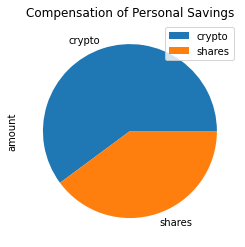

In [120]:
# Plot savings pie chart
df_savings.plot.pie(y="amount", title="Compensation of Personal Savings")


In [121]:
# Set ideal emergency fund
emergency_fund = monthly_income * 3

# Calculate total amount of savings
total_savings = crypto + shares

# Validate saving health
if total_savings > emergency_fund:
    print("Congratulations for having enough money in this fund.")
elif total_savings == emergency_fund:
    print("Congratulations on reaching this financial goal.")
elif total_savings < emergency_fund:
    print(f"Another {emergency_fund-total_savings} is needed to reach your emergency find goal.")


Congratulations for having enough money in this fund.


## Part 2 - Retirement Planning

### Monte Carlo Simulation

In [123]:
# Get current closing prices for SPY and AGG
# (use a limit=1000 parameter to call the most recent 1000 days of data)
def ticker_data(ticker):
    start_date = pd.Timestamp('2017-03-19', tz='America/New_York').isoformat()
    end_date = pd.Timestamp('2022-03-18', tz='America/New_York').isoformat()

    df_stock_data = api.get_bars(
        ticker,
        tradeapi.TimeFrame.Day,
        start = start_date,
        end = end_date,
        adjustment='raw'
    ).df

    df_stock_data = df_stock_data.drop(['trade_count', 'vwap', 'volume'], axis='columns')

    return df_stock_data

# call function for each ticker
agg = ticker_data('AGG')
spy = ticker_data('SPY')

# concatenate the ticker data and set keys for multi-indexing along columns
df_stock_data = pd.concat([spy, agg], keys=['SPY', 'AGG'], axis='columns', join='inner')
df_stock_data.head()


SPY                             AGG          \
                             open    high     low   close    open    high   
timestamp                                                                   
2017-03-20 04:00:00+00:00  237.03  237.36  236.32  236.74  107.86  108.05   
2017-03-21 04:00:00+00:00  237.49  237.61  233.58  233.76  107.93  108.27   
2017-03-22 04:00:00+00:00  233.78  234.61  233.05  234.25  108.44  108.54   
2017-03-23 04:00:00+00:00  234.01  235.34  233.60  233.94  108.44  108.51   
2017-03-24 04:00:00+00:00  234.35  235.04  232.96  233.88  108.35  108.51   

                                             
                                low   close  
timestamp                                    
2017-03-20 04:00:00+00:00  107.8401  108.05  
2017-03-21 04:00:00+00:00  107.9300  108.27  
2017-03-22 04:00:00+00:00  108.3600  108.42  
2017-03-23 04:00:00+00:00  108.2635  108.45  
2017-03-24 04:00:00+00:00  108.3100  108.36

In [124]:
# Configuring a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirtyyears = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.60,.40],
    num_simulation = 500,
    num_trading_days = 252*30
)

In [125]:
# Printing the simulation input data
MC_thirtyyears.portfolio_data.head()

SPY                                       \
                             open    high     low   close daily_return   
timestamp                                                                
2017-03-20 04:00:00+00:00  237.03  237.36  236.32  236.74          NaN   
2017-03-21 04:00:00+00:00  237.49  237.61  233.58  233.76    -0.012588   
2017-03-22 04:00:00+00:00  233.78  234.61  233.05  234.25     0.002096   
2017-03-23 04:00:00+00:00  234.01  235.34  233.60  233.94    -0.001323   
2017-03-24 04:00:00+00:00  234.35  235.04  232.96  233.88    -0.000256   

                              AGG                                         
                             open    high       low   close daily_return  
timestamp                                                                 
2017-03-20 04:00:00+00:00  107.86  108.05  107.8401  108.05          NaN  
2017-03-21 04:00:00+00:00  107.93  108.27  107.9300  108.27     0.002036  
2017-03-22 04:00:00+00:00  108.44  108.54  108.3600  108.42     0.001385  
2017-03-23 04:00:00+00:00  108.44  108.51  108.2635  108.45     0.000277  
2017-03-24 04:00:00+00:00  108.35  108.51  108.3100  108.36    -0.000830

In [126]:
# Running a Monte Carlo simulation to forecast 30 years cumulative returns
MC_thirtyyears.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/AndrewArgyrou/Documents/Monash/Fintech_Bootcamp/Homework/Week 5/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.992710,1.009854,1.003375,0.993704,0.993837,0.994393,0.989858,1.003545,0.985333,0.985558,...,0.996509,1.010715,1.002947,0.989448,0.994700,0.988681,1.008363,1.009229,0.996796,1.011995
2,1.006274,1.015315,1.014788,0.986636,0.997849,0.984974,1.012523,1.011719,0.984317,0.986156,...,0.999002,1.012695,1.007030,0.995124,0.990954,0.998820,1.004409,1.015653,1.005188,1.011398
3,1.006154,1.012261,1.015842,0.972500,0.992502,0.980153,1.015611,1.005092,0.979669,0.974157,...,1.000087,1.015062,1.013040,1.001565,1.002027,0.990228,1.008481,1.004455,1.000768,0.999762
4,1.010235,1.017093,1.018844,0.976974,0.993450,0.986845,1.027256,1.008432,0.976663,0.973905,...,0.999800,1.038664,1.022377,0.988175,0.997424,0.995200,1.016165,1.003021,1.010572,1.007002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7556,5.657420,9.790268,20.900200,5.934375,3.465722,6.284152,11.784731,10.659078,3.463703,9.982628,...,16.242493,19.115617,14.727559,37.981913,7.199390,11.882756,9.329317,20.929659,5.417346,8.264896
7557,5.647385,9.864732,20.822875,5.892100,3.467065,6.210105,11.828784,10.752583,3.495013,9.963711,...,16.082471,19.294121,14.615256,37.932888,7.189510,11.915939,9.425706,20.909163,5.429927,8.317244
7558,5.651922,9.755501,20.941494,5.936937,3.499462,6.223194,11.841357,10.702771,3.527511,9.984228,...,15.916949,19.396546,14.577877,37.670843,7.215978,11.934074,9.347775,20.851877,5.365524,8.295093
7559,5.669812,9.825697,20.964616,5.971661,3.468234,6.251980,11.916215,10.596904,3.506157,9.942814,...,15.856273,19.415875,14.503021,37.623160,7.202559,11.818385,9.443327,20.890320,5.365624,8.265212


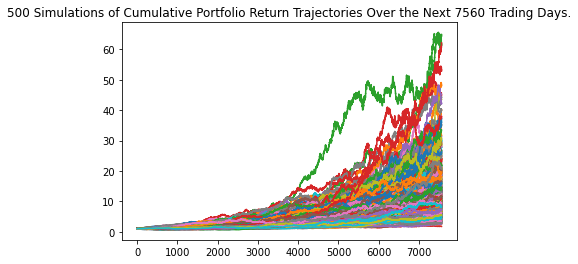

In [127]:
# Plot simulation outcomes
line_plot = MC_thirtyyears.plot_simulation()

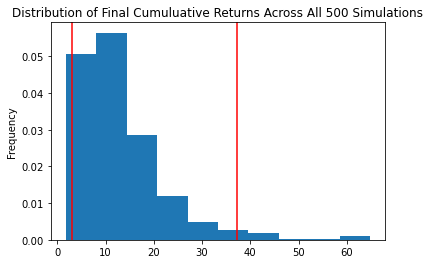

In [128]:
# Plot probability distribution and confidence intervals
dist_plot = MC_thirtyyears.plot_distribution()

### Retirement Analysis

In [129]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_thirtyyears_tbl = MC_thirtyyears.summarize_cumulative_return()

# Print summary statistics
print(MC_thirtyyears_tbl)

count           500.000000
mean             13.154200
std               9.038215
min               1.741003
25%               7.011907
50%              10.931836
75%              16.737888
max              64.829990
95% CI Lower      3.127035
95% CI Upper     37.150472
Name: 7560, dtype: float64


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `$20,000` initial investment.

In [130]:
# Set initial investment
initial_investment = 20000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $20,000
ci_lower = round(MC_thirtyyears_tbl[8]*initial_investment,2)
ci_upper = round(MC_thirtyyears_tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $20000 in the portfolio over the next 30 years will end within in the range of $62540.7 and $743009.43


### Calculate the expected portfolio return at the `95%` lower and upper confidence intervals based on a `50%` increase in the initial investment.

In [131]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
ci_lower = round(MC_thirtyyears_tbl[8]*initial_investment,2)
ci_upper = round(MC_thirtyyears_tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower} and ${ci_upper}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $93811.06 and $1114514.15


## Optional Challenge - Early Retirement


### Five Years Retirement Option

In [132]:
# Configuring a Monte Carlo simulation to forecast 5 years cumulative returns
MC_fiveyears = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.60,.40],
    num_simulation = 500,
    num_trading_days = 252*5
)

In [133]:
# Running a Monte Carlo simulation to forecast 5 years cumulative returns
MC_fiveyears.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/AndrewArgyrou/Documents/Monash/Fintech_Bootcamp/Homework/Week 5/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.015658,1.000157,0.989859,0.995805,1.003932,0.994798,1.007543,0.998437,1.004207,1.013088,...,1.002474,0.998985,1.005238,0.996561,0.999631,1.009677,1.003536,1.000701,1.006359,0.999990
2,1.011550,0.992167,0.992465,0.999804,0.997801,0.991127,1.010881,0.990699,0.998798,1.012437,...,0.999732,1.004765,1.018706,1.002841,0.999316,1.006377,1.015203,1.013898,1.007766,0.994807
3,1.016705,0.994629,0.990777,1.002189,0.995819,0.998220,1.021840,0.994383,0.989772,1.017229,...,0.996826,0.996695,1.009838,0.995408,1.000342,1.010422,1.022026,1.019663,1.002105,1.009751
4,1.012267,0.978460,1.004670,1.004184,1.001482,1.006120,1.009318,0.996928,0.989730,1.024421,...,0.980493,0.998003,1.002074,1.007045,1.010603,1.016845,1.025397,1.028417,0.999960,1.017497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.491927,1.484876,1.198615,1.429136,1.351839,1.582682,1.875597,1.392041,1.690903,2.474513,...,1.652967,1.807238,1.901910,2.232327,2.131561,1.636462,1.181237,1.489779,1.251119,1.460970
1257,1.498041,1.492244,1.186269,1.421093,1.358643,1.579727,1.865026,1.393392,1.688229,2.489068,...,1.680415,1.809018,1.894774,2.221122,2.141817,1.638813,1.188640,1.495114,1.243027,1.448634
1258,1.483646,1.502918,1.192381,1.426358,1.355691,1.576217,1.860645,1.390951,1.696432,2.494335,...,1.675386,1.791669,1.883481,2.216888,2.186220,1.630661,1.194505,1.494791,1.231127,1.435275
1259,1.475490,1.505073,1.194763,1.442080,1.349216,1.577133,1.837480,1.375992,1.704862,2.510647,...,1.699740,1.794992,1.882437,2.203549,2.212000,1.619099,1.192935,1.490061,1.240490,1.434354


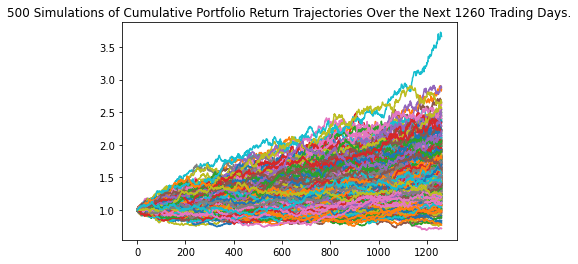

In [134]:
# Plot simulation outcomes
line_plot_5 = MC_fiveyears.plot_simulation()


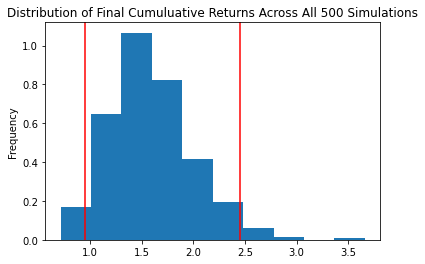

In [135]:
# Plot probability distribution and confidence intervals
dist_plot_5 = MC_fiveyears.plot_distribution()


In [136]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_fiveyears_tbl = MC_fiveyears.summarize_cumulative_return()


# Print summary statistics
print(MC_fiveyears_tbl)

count           500.000000
mean              1.587535
std               0.396650
min               0.715847
25%               1.323135
50%               1.523946
75%               1.818091
max               3.661693
95% CI Lower      0.949568
95% CI Upper      2.452428
Name: 1260, dtype: float64


In [137]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_five = round(MC_fiveyears_tbl[8]*initial_investment,2)
ci_upper_five = round(MC_fiveyears_tbl[9]*initial_investment,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 5 years will end within in the range of"
      f" ${ci_lower_five} and ${ci_upper_five}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 5 years will end within in the range of $56974.06 and $147145.67


### Ten Years Retirement Option

In [138]:
# Configuring a Monte Carlo simulation to forecast 10 years cumulative returns
MC_tenyears = MCSimulation(
    portfolio_data = df_stock_data,
    weights = [.60,.40],
    num_simulation = 500,
    num_trading_days = 252*10
)

In [139]:
# Running a Monte Carlo simulation to forecast 10 years cumulative returns
MC_tenyears.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/AndrewArgyrou/Documents/Monash/Fintech_Bootcamp/Homework/Week 5/Instructions/Starter_Code/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.992224,0.994641,0.999665,0.989514,1.004258,1.001513,1.010189,1.005138,1.006026,0.993397,...,0.999847,1.017632,0.987644,0.987887,0.990912,1.003151,0.987725,1.006778,1.000554,1.012629
2,0.993623,1.006574,1.003229,0.989626,0.994504,0.998376,1.020275,1.000884,0.992126,0.982358,...,0.999484,1.028117,0.993017,0.994462,0.983323,1.023981,0.997702,1.009314,0.998415,1.026929
3,0.992780,1.000841,1.012241,0.980785,0.991208,0.987530,1.017137,0.999594,0.993990,0.974759,...,1.003724,1.030008,0.977538,0.990736,0.976742,1.021819,0.997145,0.995501,1.003609,1.028531
4,0.980560,1.006879,1.030524,0.977079,0.988288,0.982821,1.002752,0.999239,0.999268,0.968764,...,1.003417,1.039867,0.979144,0.991907,0.956684,1.037075,0.994042,0.997502,1.010903,1.007905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2516,1.554782,2.809100,2.102602,1.201454,7.876081,2.050436,2.262697,2.796839,3.749777,5.776076,...,3.944607,4.140040,1.800368,2.249053,1.818217,3.211904,3.864013,2.030645,2.526810,1.565687
2517,1.556978,2.819842,2.091024,1.186148,7.842315,2.054102,2.266093,2.751745,3.796306,5.775638,...,3.972438,4.165351,1.806594,2.267515,1.811563,3.203772,3.873430,2.029526,2.508536,1.562229
2518,1.560660,2.847619,2.076506,1.172819,7.855264,2.058746,2.269443,2.745858,3.772565,5.778870,...,3.935673,4.205092,1.791223,2.267497,1.814163,3.160645,3.877464,2.010950,2.494040,1.557196
2519,1.558610,2.846120,2.076179,1.190811,7.973789,2.098080,2.266580,2.753979,3.764927,5.827163,...,3.868712,4.167023,1.783969,2.281893,1.831504,3.177403,3.846120,1.992859,2.499949,1.555182


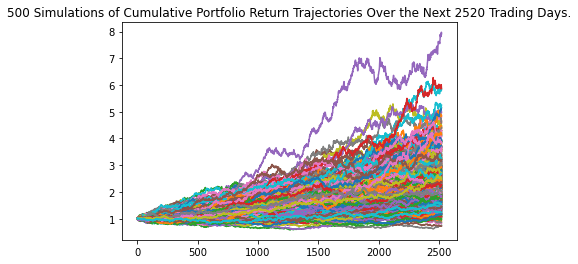

In [140]:
# Plot simulation outcomes
line_plot_10 = MC_tenyears.plot_simulation()


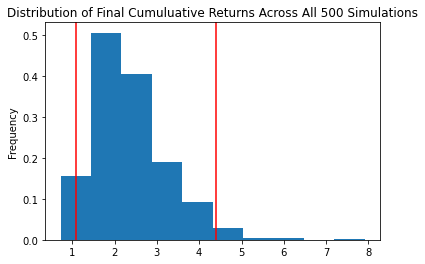

In [141]:
# Plot probability distribution and confidence intervals
dist_plot_10 = MC_tenyears.plot_distribution()

In [142]:
# Fetch summary statistics from the Monte Carlo simulation results
MC_tenyears_tbl = MC_tenyears.summarize_cumulative_return()

# Print summary statistics
print(MC_tenyears_tbl)

count           500.000000
mean              2.351758
std               0.888669
min               0.719912
25%               1.725018
50%               2.216692
75%               2.810339
max               7.916938
95% CI Lower      1.090277
95% CI Upper      4.405844
Name: 2520, dtype: float64


In [143]:
# Set initial investment
initial_investment = 60000

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $60,000
ci_lower_ten = round(MC_tenyears_tbl[8]*60000,2)
ci_upper_ten = round(MC_tenyears_tbl[9]*60000,2)

# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 10 years will end within in the range of"
      f" ${ci_lower_ten} and ${ci_upper_ten}")

There is a 95% chance that an initial investment of $60000 in the portfolio over the next 10 years will end within in the range of $65416.61 and $264350.66
